<a href="https://colab.research.google.com/github/jrzkaminski/dmm_homeworks/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3

* Num of servers: 4 (4 or 5 for dynamic case)
* Probability to wait for customers: ~50% (fit feasible parameters)
* Random arrival & Random Service (the same for all servers)

## 0. Importing libs and event queue defining

In [2]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from simpy import *
from typing import List

In [4]:
# Queue of Events
class EventsQueue:
    def __init__(self):
        self.globalTime = 0
        self.MEvents = []

    def QueueSize(self):
        return len(self.MEvents)

    def AddEvent(self, MEvent):
        count = len(self.MEvents)
        if count == 0:
            self.MEvents.append(MEvent)
            return 0

        if MEvent.eTime >= self.MEvents[count - 1].eTime:
            self.MEvents.append(MEvent)
            return 0

        for i in range(0, count - 1):
            if MEvent.eTime >= self.MEvents[i].eTime:
                if MEvent.eTime < self.MEvents[i + 1].eTime:
                    self.MEvents.insert(i + 1, MEvent)
                    return 0

    def ProcessNextEvent(self):
        if len(self.MEvents) == 0:
            return 0
        self.MEvents[0].Execute()
        self.globalTime = self.MEvents[0].eTime
        del self.MEvents[0]


# Discrete Event System Specification
class DEVS:
    EQ = EventsQueue()
    GlobalTime = 0.0

    def __init__(self):
        pass

    @staticmethod
    def ProcessNextEvent():
        DEVS.EQ.ProcessNextEvent()
        DEVS.GlobalTime = DEVS.EQ.globalTime

In [5]:
maxAngents = 200
arrivalRateMin = 1
arrivalRateMax = 6
service_xk = np.arange(6) + 20
service_pk = (0.1, 0.2, 0.3, 0.25, 0.1, 0.05)
custm = stats.rv_discrete(name='custm', values=(service_xk, service_pk))

## 1. General queue

Time 0  Arrival Event of agent 0
server is busy
Time 5  Arrival Event of agent 1
server is busy
Time 9  Arrival Event of agent 2
server is busy
Time 14  Arrival Event of agent 3
server is busy
Time 20  Arrival Event of agent 4
customerQueue = 1
Time 22  Arrival Event of agent 5
customerQueue = 2
Time 24 Service finished
take new customer from the queue
Time 25 Service finished
take new customer from the queue
Time 25  Arrival Event of agent 6
customerQueue = 1
Time 29  Arrival Event of agent 7
customerQueue = 2
Time 32 Service finished
take new customer from the queue
Time 32  Arrival Event of agent 8
customerQueue = 2
Time 38 Service finished
take new customer from the queue
Time 38  Arrival Event of agent 9
customerQueue = 2
Time 41  Arrival Event of agent 10
customerQueue = 3
Time 42  Arrival Event of agent 11
customerQueue = 4
Time 44  Arrival Event of agent 12
customerQueue = 5
Time 46 Service finished
take new customer from the queue
Time 47 Service finished
take new customer fro

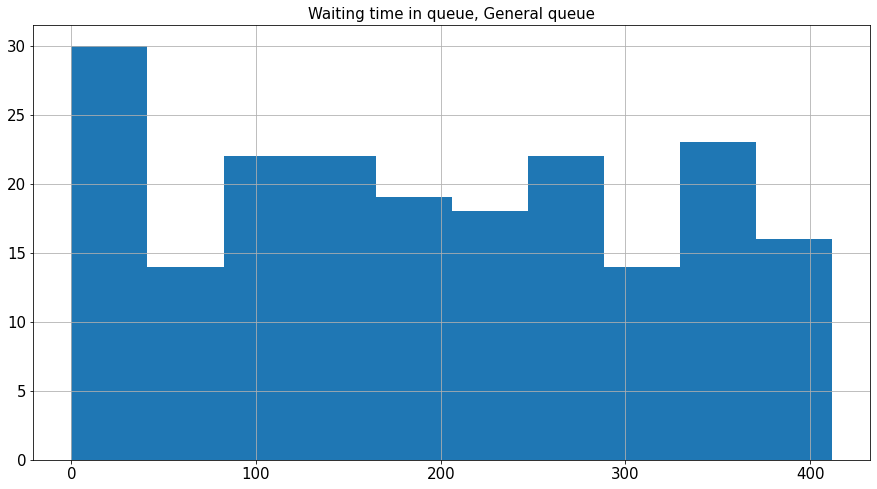

In [6]:
# ---- Customer Statistics ----


class customerStat:
    def __init__(self):
        self.id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0

# ---- Arrival Event ----


class ArrivalEvent:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if(len(DEVS.stats) > 0):
            customer.interArrivalTime = customer.arrivalTime - \
                DEVS.stats[-1].arrivalTime

        print("Time %d" % self.eTime,
              " Arrival Event of agent {0}".format(customer.id))
        if(DEVS.newId < maxAngents - 1):
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime + \
                random.randint(arrivalRateMin, arrivalRateMax)
            DEVS.EQ.AddEvent(NextArrival)
        # server is Free
        if (pass_customer()):
            print("server is busy")
            Service = ServiceEvent()
            serviceTime = custm.rvs()
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime
            Service.eTime = self.eTime + serviceTime
            Service.id = customer.id
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            # increase waiting line
            DEVS.customerQueue.append(customer.id)
            print("customerQueue = %d" % len(DEVS.customerQueue))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)

# ---- Service (END) Event ----


class ServiceEvent:
    def __init__(self):
        self.eTime = 0.0
        self.id = 0

    def Execute(self):
        ind = [i for i, val in enumerate(DEVS.stats) if val.id == self.id][0]
        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - \
            DEVS.stats[ind].arrivalTime
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - \
            DEVS.stats[ind].arrivalTime  # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - \
            DEVS.lastServedTime

        print("Time %d" % self.eTime, "Service finished")
        if(len(DEVS.customerQueue) > 0):
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i, val in enumerate(DEVS.stats) if val.id == qid][0]
            Service = ServiceEvent()
            serviceTime = custm.rvs()
            Service.eTime = self.eTime + serviceTime
            Service.id = qid
            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime
            DEVS.EQ.AddEvent(Service)
            print("take new customer from the queue")
        else:
            pass_customer(False)
            print("server is Idle (do nothing)")

        DEVS.lastServedTime = self.eTime


# ---- Passing customer to random idling server ----
def pass_customer(Idle=True):
    i = [n for n, x in enumerate(DEVS.serversIdle) if x == Idle]
    if (len(i) > 0):
        DEVS.serversIdle[random.choice(i)] = not Idle
        return True
    return False

# run simulation
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)

# simulation attributes
DEVS.customerQueue = []
DEVS.stats = []
DEVS.newId = 0
DEVS.serversIdle = [True, True, True, True]
DEVS.lastServedTime = 0  # for Idle time

# --- SIMULATION ---
while DEVS.EQ.QueueSize() > 0:
    DEVS.ProcessNextEvent()

# --- STATISTICS ---

#  --- store all in file  ---
f = open('output.csv', 'w')
f.write("Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n")
for s in DEVS.stats:
    f.write("{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(s.id, s.interArrivalTime, s.arrivalTime,
            s.serviceTime, s.serviceBegins, s.waitingTimeInQueue, s.serviceEnds, s.timeInSystem, s.idleTimeOfServer))
f.close()

# 1) Average waiting time in queue
avTimeInQueue = sum([x.waitingTimeInQueue for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

# 2) Probability that a customer has to wait
probToWait = len(
    [x for x in DEVS.stats if x.waitingTimeInQueue > 0])/len(DEVS.stats)
print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

# 3) Probability of an Idle server
probIdle = sum([x.idleTimeOfServer for x in DEVS.stats])/DEVS.GlobalTime
print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

# 4) Average service time (theoretical 3.2)
avServiceTime = sum([x.serviceTime for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage service time: {0:.2f}".format(avServiceTime))

# 5) Average time between arrivals (theoretical 4.5)
avTimeBetwArr = sum(
    [x.interArrivalTime for x in DEVS.stats])/(len(DEVS.stats)-1)
print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

# 6) Average waiting time for those who wait
numOfCustWhoWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0])
avTimeWhoWait = sum(
    [x.waitingTimeInQueue for x in DEVS.stats])/numOfCustWhoWait
print("\nAverage waiting time for those who wait: {0:.2f}".format(
    avTimeWhoWait))

# 7) Average time a customer spends in the system
avTimeInTheSystem1 = sum([x.timeInSystem for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage time a customer spends in the system: {0:.2f}".format(
    avTimeInTheSystem1))

avTimeInTheSystem2 = avTimeInQueue + avServiceTime
print("\nAverage time a customer spends in the system (alternative): {0:.2f}".format(
    avTimeInTheSystem2))


def DrawSampleHistogram(R, title, bins=None):
    fig = plt.figure(figsize=(15, 8))
    x = np.arange(len(R))
    plt.grid()
    if(bins is None):
        plt.hist(R, range=None)
    else:
        plt.hist(R, bins=bins, range=None)
    plt.title(title, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()


DrawSampleHistogram(
    [x.waitingTimeInQueue for x in DEVS.stats], "Waiting time in queue, General queue")


## 2. Shortest queue

Time 0  Arrival Event of agent 0
server is Busy
Time 2  Arrival Event of agent 1
server is Busy
Time 7  Arrival Event of agent 2
server is Busy
Time 8  Arrival Event of agent 3
server is Busy
Time 12  Arrival Event of agent 4
Costumer assigned to queue 1
Time 15  Arrival Event of agent 5
Costumer assigned to queue 1
Time 17  Arrival Event of agent 6
Costumer assigned to queue 1
Time 21 Service finished
Time 23 Service finished
Time 23  Arrival Event of agent 7
Costumer assigned to queue 1
Time 26  Arrival Event of agent 8
Costumer assigned to queue 1
Time 29 Service finished
Time 30  Arrival Event of agent 9
Costumer assigned to queue 1
Time 31 Service finished
server is Idle (do nothing)
Time 31  Arrival Event of agent 10
server is Busy
Time 35  Arrival Event of agent 11
Costumer assigned to queue 1
Time 38  Arrival Event of agent 12
Costumer assigned to queue 2
Time 39  Arrival Event of agent 13
Costumer assigned to queue 2
Time 41 Service finished
Time 42  Arrival Event of agent 14


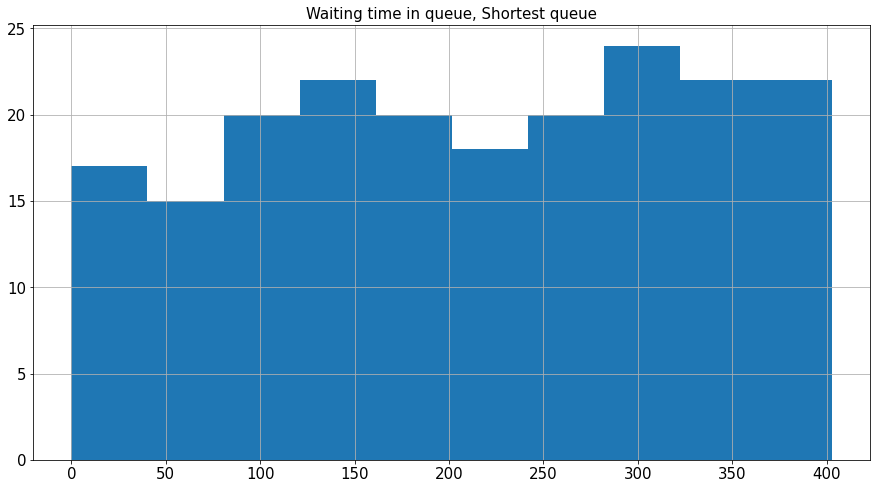

In [7]:
custm = stats.rv_discrete(name='custm', values=(service_xk, service_pk))


# ---- Customer Statistics ----
class customerStat:
    def __init__(self):
        self.id = -1
        self.server_id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0
        


# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if len(DEVS.stats) > 0:
            customer.interArrivalTime = customer.arrivalTime - \
                DEVS.stats[-1].arrivalTime

        print("Time %d" % self.eTime,
              " Arrival Event of agent {0}".format(customer.id))
        if DEVS.newId < maxAngents - 1:
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime + \
                random.randint(arrivalRateMin, arrivalRateMax)
            DEVS.EQ.AddEvent(NextArrival)

        # server is Free
        if any(DEVS.serverIdle):
            idle_server = DEVS.serverIdle.index(True)
            DEVS.serverIdle[idle_server] = False
            print("server is Busy")
            Service = ServiceEvent()
            serviceTime = custm.rvs()
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime  # current time
            Service.eTime = self.eTime + serviceTime
            Service.id = customer.id
            Service.server_id = idle_server
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            shortest_queue = DEVS.customerQueues.index(
                min(DEVS.customerQueues, key=len))
            # increase waiting line
            DEVS.customerQueues[shortest_queue].append(customer.id)
            customer.server_id = shortest_queue
            print("Costumer assigned to queue %d" %
                  len(DEVS.customerQueues[shortest_queue]))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


# ---- Service (END) Event ----
class ServiceEvent:
    def __init__(self):
        self.eTime = 0.0
        self.id = 0
        self.server_id = 0

    def Execute(self):
        ind = [i for i, val in enumerate(DEVS.stats) if val.id == self.id][0]
        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - \
            DEVS.stats[ind].arrivalTime
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - \
            DEVS.stats[ind].arrivalTime  # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - \
            DEVS.lastServedTime

        print("Time %d" % self.eTime, "Service finished")
        if len(DEVS.customerQueues[self.server_id]) > 0:
            qid = DEVS.customerQueues[self.server_id].pop(0)
            qind = [i for i, val in enumerate(DEVS.stats) if val.id == qid][0]
            Service = ServiceEvent()
            serviceTime = custm.rvs()
            Service.eTime = self.eTime + serviceTime
            Service.id = qid
            Service.server_id = self.server_id
            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime
            DEVS.EQ.AddEvent(Service)
        else:
            DEVS.serverIdle[self.server_id] = True
            print("server is Idle (do nothing)")

        DEVS.lastServedTime = self.eTime


# run simulation
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)

# simulation attributes
DEVS.customerQueues = [[] for i in range(4)]
DEVS.stats = []
DEVS.newId = 0
DEVS.serverIdle = [True for _ in range(4)]
DEVS.lastServedTime = 0  # for Idle time

# --- SIMULATION ---
while DEVS.EQ.QueueSize() > 0:
    DEVS.ProcessNextEvent()

# --- STATISTICS ---

#  --- store all in file  ---
f = open('output.csv', 'w')
f.write("Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n")
for s in DEVS.stats:
    f.write("{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(s.id, s.interArrivalTime, s.arrivalTime,
            s.serviceTime, s.serviceBegins, s.waitingTimeInQueue, s.serviceEnds, s.timeInSystem, s.idleTimeOfServer))
f.close()

# 1) Average waiting time in queue
avTimeInQueue = sum([x.waitingTimeInQueue for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

# 2) Probability that a customer has to wait
probToWait = len(
    [x for x in DEVS.stats if x.waitingTimeInQueue > 0])/len(DEVS.stats)
print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

# 3) Probability of an Idle server
probIdle = sum([x.idleTimeOfServer for x in DEVS.stats]) / DEVS.GlobalTime
print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

# 4) Average service time (theoretical 3.2)
avServiceTime = sum([x.serviceTime for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage service time: {0:.2f}".format(avServiceTime))

# 5) Average time between arrivals (theoretical 4.5)
avTimeBetwArr = sum(
    [x.interArrivalTime for x in DEVS.stats])/(len(DEVS.stats)-1)
print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

# 6) Average waiting time for those who wait
numOfCustWhoWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0])
if numOfCustWhoWait:
    avTimeWhoWait = sum(
        [x.waitingTimeInQueue for x in DEVS.stats]) / numOfCustWhoWait
    print("\nAverage waiting time for those who wait: {0:.2f}".format(
        avTimeWhoWait))

# 7) Average time a customer spends in the system
avTimeInTheSystem1 = sum(
    [x.timeInSystem for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage time a customer spends in the system: {0:.2f}".format(
    avTimeInTheSystem1))

avTimeInTheSystem2 = avTimeInQueue + avServiceTime
print("\nAverage time a customer spends in the system (alternative): {0:.2f}".format(
    avTimeInTheSystem2))


def DrawSampleHistogram(R, title, bins=None):
    fig = plt.figure(figsize=(15, 8))
    x = np.arange(len(R))
    plt.grid()
    if(bins is None):
        plt.hist(R, range=None)
    else:
        plt.hist(R, bins=bins, range=None)
    plt.title(title, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()


DrawSampleHistogram(
    [x.waitingTimeInQueue for x in DEVS.stats], "Waiting time in queue, Shortest queue")


Выходные данные были обрезаны до нескольких последних строк (5000).
3322.2465 job795: Waited  3.758
3325.2219 job797: Arrival 
3325.3804 job787: Finished
3325.3804 job793: Waited 18.424
3326.2817 job798: Arrival 
3327.3856 job799: Arrival 
3328.2287 job793: Finished
3328.2287 job799: Waited  0.843
3330.8148 job800: Arrival 
3331.0169 job795: Finished
3331.0169 job797: Waited  5.795
3333.7160 job797: Finished
3333.7160 job798: Waited  7.434
3334.8594 job781: Finished
3334.8594 job785: Waited 42.695
3337.5433 job798: Finished
3348.2575 job785: Finished
3348.2575 job789: Waited 49.104
3349.9053 job801: Arrival 
3352.7014 job789: Finished
3352.7014 job801: Waited  2.796
3352.9509 job791: Finished
3352.9509 job794: Waited 44.215
3353.4870 job802: Arrival 
3354.3211 job803: Arrival 
3354.3211 job803: Waited  0.000
3355.2671 job803: Finished
3355.5941 job799: Finished
3355.5941 job800: Waited 24.779
3355.7999 job804: Arrival 
3355.7999 job804: Waited  0.000
3356.7876 job805: Arrival 
3358.241

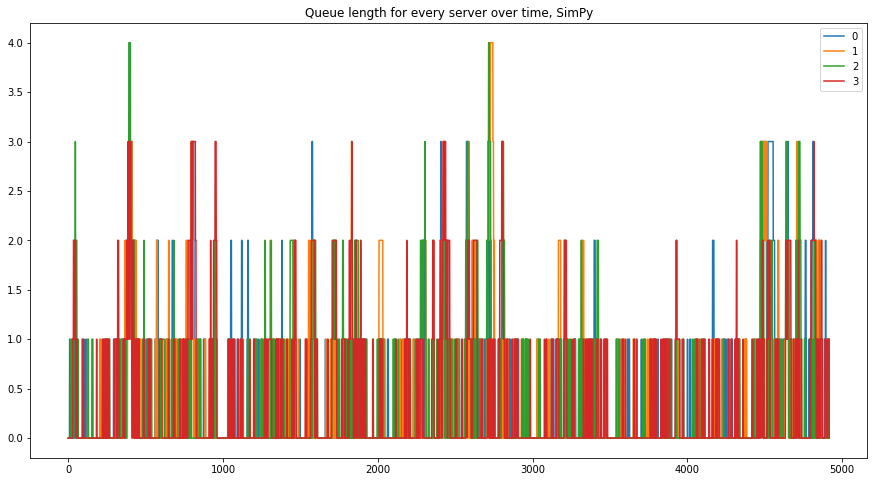

In [8]:
Time = 10000.0
mean_service_time = 10.0
mean_arrival_time = 4.0 
service_number = 4
d = 2
jobs_number = 0
Queues = []



def NoInSystem(R):
    return len(R.put_queue) + len(R.users)


def QueueSelector(d, services):
    return random.sample(range(len(services)), d)


def job(env, name, services):
    arrive = env.now
    wait_arr = []
    Qlength = {i: NoInSystem(services[i]) for i in QueueSelector(d, services)}
    print("%7.4f %s: Arrival " % (arrive, name))
    Queues.append({i: len(services[i].put_queue) for i in range(len(services))})
    choice = [k for k, v in sorted(Qlength.items(), key=lambda a: a[1])][0]
    with services[choice].request() as req:
        yield req
        wait = env.now - arrive
        print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        tib = random.expovariate(1.0 / mean_service_time)
        yield env.timeout(tib)
        Queues.append({i: len(services[i].put_queue) for i in range(len(services))})
        print('%7.4f %s: Finished' % (env.now, name))


def Source(env, jobs_number, interval, services):
        while True:  # Needed for infinite case as True refers to "until".
            i = jobs_number
            jobs_number += 1
            c = job(env, 'job%02d' % i, services)
            env.process(c)
            t = random.expovariate(1.0 / interval)
            yield env.timeout(t)


# Setup and start the simulation
random.seed(42)
env = Environment()

services = {i: Resource(env) for i in range(service_number)}
env.process(Source(env, jobs_number, mean_arrival_time, services))
env.run(until=Time)

df = pd.DataFrame(Queues).plot(figsize=(15, 8), title = "Queue length for every server over time, SimPy")

In [9]:
df

## 3. Dynamic General queue

Time 0  Arrival Event of agent 0
server is Busy
Time 5  Arrival Event of agent 1
server is Busy
Time 10  Arrival Event of agent 2
server is Busy
Time 13  Arrival Event of agent 3
server is Busy
Time 16  Arrival Event of agent 4
Extra server added
server is Busy
Time 18  Arrival Event of agent 5
customerQueue = 1
Time 19  Arrival Event of agent 6
customerQueue = 2
Time 22  Arrival Event of agent 7
customerQueue = 3
Time 23 Service finished
take new customer from the queue
Time 25  Arrival Event of agent 8
customerQueue = 3
Time 27 Service finished
take new customer from the queue
Time 29  Arrival Event of agent 9
customerQueue = 3
Time 33 Service finished
take new customer from the queue
Time 33  Arrival Event of agent 10
customerQueue = 3
Time 34 Service finished
take new customer from the queue
Time 35  Arrival Event of agent 11
customerQueue = 3
Time 37  Arrival Event of agent 12
customerQueue = 4
Time 39 Service finished
take new customer from the queue
Time 40  Arrival Event of age

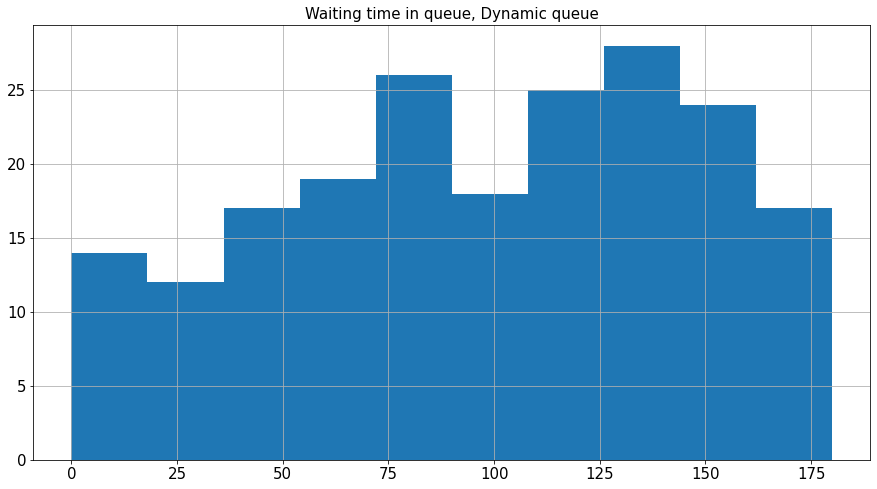

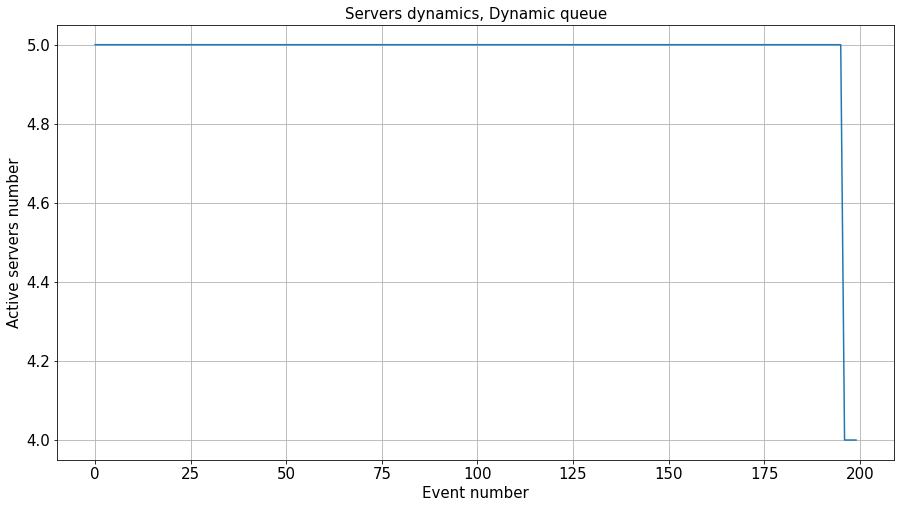

In [14]:
# ---- Customer Statistics ----


class customerStat:
    def __init__(self):
        self.id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0
        self.serversNumber = default

# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if(len(DEVS.stats) > 0):
            customer.interArrivalTime = customer.arrivalTime - \
                DEVS.stats[-1].arrivalTime

        print("Time %d" % self.eTime,
              " Arrival Event of agent {0}".format(customer.id))
        if(DEVS.newId < maxAngents-1):
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime + \
                random.randint(arrivalRateMin, arrivalRateMax)
            DEVS.EQ.AddEvent(NextArrival)
        # server is Free
        if (pass_customer_add_server()):
            print("server is Busy")
            Service = ServiceEvent()
            serviceTime = custm.rvs()
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime  # current time
            Service.eTime = self.eTime+serviceTime
            Service.id = customer.id
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            # increase waiting line
            DEVS.customerQueue.append(customer.id)
            print("customerQueue = %d" % len(DEVS.customerQueue))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)

# ---- Service (END) Event ----


class ServiceEvent:
    def __init__(self):
        self.eTime = 0.0
        self.id = 0

    def Execute(self):
        ind = [i for i, val in enumerate(DEVS.stats) if val.id == self.id][0]
        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - \
            DEVS.stats[ind].arrivalTime
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - \
            DEVS.stats[ind].arrivalTime  # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - \
            DEVS.lastServedTime
        DEVS.stats[ind].serversNumber = DEVS.serversNumber

        print("Time %d" % self.eTime, "Service finished")
        if(len(DEVS.customerQueue) > 0):
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i, val in enumerate(DEVS.stats) if val.id == qid][0]
            Service = ServiceEvent()
            serviceTime = custm.rvs()
            Service.eTime = self.eTime+serviceTime
            Service.id = qid
            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime
            DEVS.EQ.AddEvent(Service)
            print("take new customer from the queue")
        else:
            remove_server()
            print("server is Idle (do nothing)")

        DEVS.lastServedTime = self.eTime


# ---- Passing customer to random idling server ----


def pass_customer_add_server():
    i = [n for n, x in enumerate(DEVS.servers_idle) if x == True]
    if (len(i) > 0):
        DEVS.servers_idle[random.choice(i)] = False
        return True

    if (DEVS.serversNumber == default):
        DEVS.servers_idle.append(False)
        DEVS.serversNumber = override
        print("Extra server added")
        return True
    return False

# ---- Removing extra server ----


def remove_server():
    i = [n for n, x in enumerate(DEVS.servers_idle) if x == False]
    if (len(i) > 0):
        DEVS.servers_idle[random.choice(i)] = True

    idling_servs = [n for n, x in enumerate(DEVS.servers_idle) if x == False]
    if (len(idling_servs) >= 2 and DEVS.serversNumber == override):
        DEVS.servers_idle.pop(idling_servs[0])
        DEVS.serversNumber = default
        print("Extra server removed")

# run simulation
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)

# simulation attributes
DEVS.customerQueue = []
DEVS.stats = []
DEVS.newId = 0
default = 4
DEVS.serversNumber = default
override = default + 1
DEVS.servers_idle = [True, True, True, True]
DEVS.lastServedTime = 0  # for Idle time

# --- SIMULATION ---
while DEVS.EQ.QueueSize() > 0:
    DEVS.ProcessNextEvent()

# --- STATISTICS ---

#  --- store all in file  ---
f = open('output.csv', 'w')
f.write("Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n")
for s in DEVS.stats:
    f.write("{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(s.id, s.interArrivalTime, s.arrivalTime,
            s.serviceTime, s.serviceBegins, s.waitingTimeInQueue, s.serviceEnds, s.timeInSystem, s.idleTimeOfServer))
f.close()

# 1) Average waiting time in queue
avTimeInQueue = sum([x.waitingTimeInQueue for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

# 2) Probability that a customer has to wait
probToWait = len(
    [x for x in DEVS.stats if x.waitingTimeInQueue > 0])/len(DEVS.stats)
print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

# 3) Probability of an Idle server
probIdle = sum([x.idleTimeOfServer for x in DEVS.stats])/DEVS.GlobalTime
print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

# 4) Average service time (theoretical 3.2)
avServiceTime = sum([x.serviceTime for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage service time: {0:.2f}".format(avServiceTime))

# 5) Average time between arrivals (theoretical 4.5)
avTimeBetwArr = sum(
    [x.interArrivalTime for x in DEVS.stats])/(len(DEVS.stats)-1)
print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

# 6) Average waiting time for those who wait
numOfCustWhoWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0])
try:
    avTimeWhoWait = sum(
        [x.waitingTimeInQueue for x in DEVS.stats])/numOfCustWhoWait
except ZeroDivisionError:
    avTimeWhoWait = 0
print("\nAverage waiting time for those who wait: {0:.2f}".format(
    avTimeWhoWait))

# 7) Average time a customer spends in the system
avTimeInTheSystem1 = sum([x.timeInSystem for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage time a customer spends in the system: {0:.2f}".format(
    avTimeInTheSystem1))

avTimeInTheSystem2 = avTimeInQueue + avServiceTime
print("\nAverage time a customer spends in the system (alternative): {0:.2f}".format(
    avTimeInTheSystem2))


def DrawServerNumbers(R, title):
    fig = plt.figure(figsize=(15, 8))
    plt.grid()
    plt.plot(R)
    plt.title(title, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Event number", fontsize=15)
    plt.ylabel("Active servers number", fontsize=15)
    plt.show()


def DrawSampleHistogram(R, title, bins=None):
    fig = plt.figure(figsize=(15, 8))
    x = np.arange(len(R))
    plt.grid()
    if(bins is None):
        plt.hist(R, range=None)
    else:
        plt.hist(R, bins=bins, range=None)
    plt.title(title, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()


DrawSampleHistogram(
    [x.waitingTimeInQueue for x in DEVS.stats], "Waiting time in queue, Dynamic queue")
DrawServerNumbers([x.serversNumber for x in DEVS.stats], "Servers dynamics, Dynamic queue")


## 4. Dynamic Shortest queue

Time 0  Arrival Event of agent 0
server is Busy
Time 6  Arrival Event of agent 1
server is Busy
Time 9  Arrival Event of agent 2
server is Busy
Time 13  Arrival Event of agent 3
server is Busy
Time 18  Arrival Event of agent 4
Added new worker with id 4
server is Busy
Time 21 Service finished
server is Idle (do nothing)
Time 23  Arrival Event of agent 5
server is Busy
Time 25  Arrival Event of agent 6
0
customerQueue = 1
Time 30 Service finished
server is Idle (do nothing)
Time 30  Arrival Event of agent 7
server is Busy
Time 32 Service finished
server is Idle (do nothing)
Time 33  Arrival Event of agent 8
server is Busy
Time 34 Service finished
server is Idle (do nothing)
Time 38  Arrival Event of agent 9
server is Busy
Time 40 Service finished
server is Busy
take new customer from the queue
Time 44  Arrival Event of agent 10
0
customerQueue = 1
Time 46 Service finished
server is Busy
take new customer from the queue
Time 48  Arrival Event of agent 11
0
customerQueue = 1
Time 52 Servi

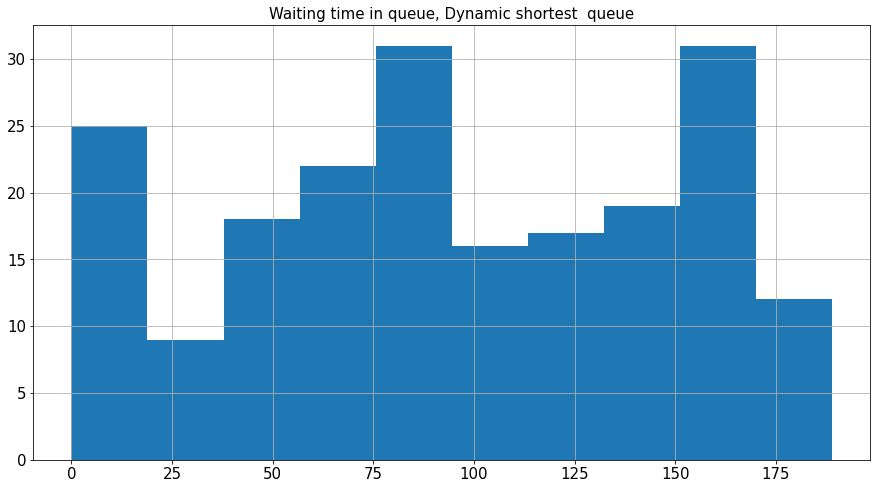

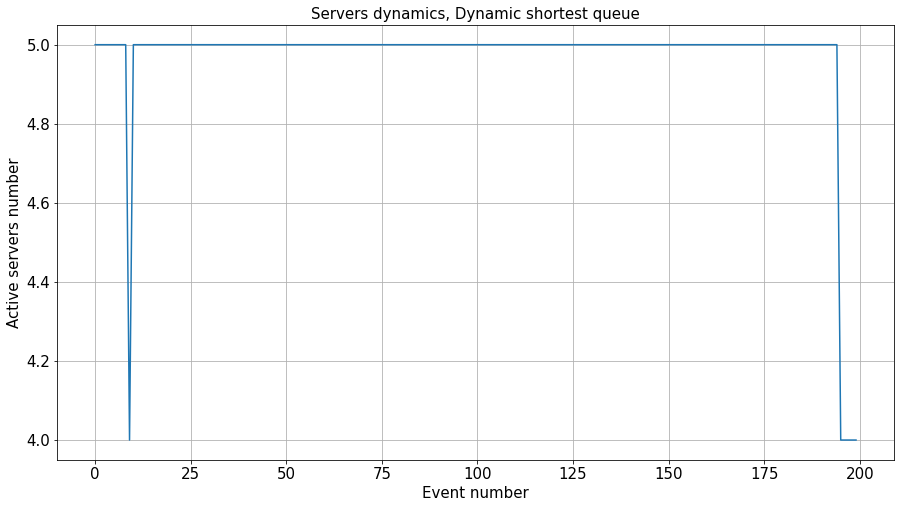

In [15]:
Servers_counter = 4
default_servers_number = 4
# ---- Customer Statistics ----
class customerStat:
    def __init__(self):
        self.id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0
        self.server_id = -1

# ---- Arrival Event ----
class ArrivalEvent:
    def __init__(self):
        self.eTime = 0.0
        
    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if len(DEVS.stats) > 0:
            customer.interArrivalTime = customer.arrivalTime - DEVS.stats[-1].arrivalTime

        print("Time %d"%self.eTime," Arrival Event of agent {0}".format(customer.id))
        if DEVS.newId < maxAngents - 1:
            NextArrival = ArrivalEvent()
            NextArrival.eTime = self.eTime + random.randint(arrivalRateMin, arrivalRateMax)
            DEVS.EQ.AddEvent(NextArrival)

        # there is free workers
        idle_workers = [server_id for server_id, is_idle in DEVS.serverIdle.items() if is_idle]
        if idle_workers:
            idle_server = random.choice(idle_workers)
            start_service(customer, idle_server, self.eTime)
        # adding new worker
        elif len(DEVS.customerQueues) == default_servers_number:
            new_server_id = extra_server()
            start_service(customer, new_server_id, self.eTime)
        # finding shortest queue
        else:
            shortest_queue = random.choice(get_shortest_queues())
            # increase waiting line
            DEVS.customerQueues[shortest_queue].append(customer.id)
            customer.server_id = shortest_queue
            print("customerQueue = %d" % len(DEVS.customerQueues[shortest_queue]))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


# ---- Service (END) Event ----
class ServiceEvent:
    def __init__(self):
        self.eTime = 0.0
        self.id = 0
        self.server_id = 0
        
    def Execute(self):        
        ind = [i for i, val in enumerate(DEVS.stats) if val.id == self.id][0]
        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime 
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        f = True
        print("Time %d"%self.eTime, "Service finished")
        if len(DEVS.customerQueues[self.server_id]) > 0:
            qid = DEVS.customerQueues[self.server_id].pop(0)
            customer = DEVS.stats[[i for i, val in enumerate(DEVS.stats) if val.id == qid][0]]
            start_service(customer, self.server_id, self.eTime)
            DEVS.default_servers_number.append(Servers_counter)
            f = False
            print("take new customer from the queue")            
        else:
            DEVS.serverIdle[self.server_id] = True
            idle_workers = [server_id for server_id, is_idle in DEVS.serverIdle.items() if is_idle]
            if len(idle_workers) > 1 and len(DEVS.customerQueues) == default_servers_number + 1:
                extra_server_rm(random.choice(idle_workers))
                DEVS.default_servers_number.append(Servers_counter)
                f=False
            print("server is Idle (do nothing)")
        if (f):
            DEVS.default_servers_number.append(Servers_counter)
        DEVS.lastServedTime = self.eTime


def extra_server():
    new_server_id = max(DEVS.customerQueues.keys()) + 1
    DEVS.customerQueues[new_server_id] = []
    DEVS.serverIdle[new_server_id] = True
    global Servers_counter
    Servers_counter += 1
    print(f"Added new worker with id {new_server_id}")
    return new_server_id


def extra_server_rm(server_id):
    del DEVS.customerQueues[server_id]
    del DEVS.serverIdle[server_id]
    global Servers_counter
    Servers_counter -= 1
    print(f"Server {server_id} removed")


def get_shortest_queues():
    min_length = len(min(DEVS.customerQueues.values(), key=len))
    print(min_length)
    return [queue_id for queue_id, queue in DEVS.customerQueues.items() if len(queue) == min_length]


def start_service(customer, server_id, now):
    DEVS.serverIdle[server_id] = False
    print("server is Busy")
    Service = ServiceEvent()
    serviceTime = custm.rvs()
    customer.serviceTime = serviceTime
    customer.serviceBegins = now  # current time
    Service.eTime = now + serviceTime
    Service.id = customer.id
    Service.server_id = server_id
    DEVS.EQ.AddEvent(Service)

# run simulation
AE = ArrivalEvent()
DEVS.EQ.AddEvent(AE)

# simulation attributes
DEVS.customerQueues = {i: [] for i in range(Servers_counter)}
DEVS.stats = []
DEVS.newId = 0
DEVS.serverIdle = {i: True for i in range(Servers_counter)}
DEVS.default_servers_number = []
DEVS.lastServedTime = 0 # for Idle time

# --- SIMULATION ---
while DEVS.EQ.QueueSize() > 0:
    DEVS.ProcessNextEvent()  

# --- STATISTICS ---

#  --- store all in file  --- 
f = open('output.csv','w')
f.write("Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n")
for s in DEVS.stats:
    f.write("{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(s.id,s.interArrivalTime,s.arrivalTime,s.serviceTime,s.serviceBegins,s.waitingTimeInQueue,s.serviceEnds,s.timeInSystem,s.idleTimeOfServer))    
f.close()

# 1) Average waiting time in queue
avTimeInQueue = sum([x.waitingTimeInQueue for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

# 2) Probability that a customer has to wait
probToWait = len([x for x in DEVS.stats if x.waitingTimeInQueue>0])/len(DEVS.stats)
print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

# 3) Probability of an Idle server
probIdle = sum([x.idleTimeOfServer for x in DEVS.stats]) / DEVS.GlobalTime
print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

# 4) Average service time (theoretical 3.2)
avServiceTime = sum([x.serviceTime for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage service time: {0:.2f}".format(avServiceTime))

# 5) Average time between arrivals (theoretical 4.5)
avTimeBetwArr = sum([x.interArrivalTime for x in DEVS.stats])/(len(DEVS.stats)-1)
print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

# 6) Average waiting time for those who wait
numOfCustWhoWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0])
if numOfCustWhoWait:
    avTimeWhoWait = sum([x.waitingTimeInQueue for x in DEVS.stats]) / numOfCustWhoWait
    print("\nAverage waiting time for those who wait: {0:.2f}".format(avTimeWhoWait))

# 7) Average time a customer spends in the system
avTimeInTheSystem1 = sum([x.timeInSystem for x in DEVS.stats]) / len(DEVS.stats)
print("\nAverage time a customer spends in the system: {0:.2f}".format(avTimeInTheSystem1))

avTimeInTheSystem2 = avTimeInQueue + avServiceTime
print("\nAverage time a customer spends in the system (alternative): {0:.2f}".format(avTimeInTheSystem2))

def DrawServerNumbers(R, title):
    fig = plt.figure(figsize=(15, 8))
    plt.grid()
    plt.plot(R)
    plt.title(title, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Event number", fontsize=15)
    plt.ylabel("Active servers number", fontsize=15)
    plt.show()


def DrawSampleHistogram(R, title, bins=None):
    fig = plt.figure(figsize=(15, 8))
    x = np.arange(len(R))
    plt.grid()
    if(bins is None):
        plt.hist(R, range=None)
    else:
        plt.hist(R, bins=bins, range=None)
    plt.title(title, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()


DrawSampleHistogram(
    [x.waitingTimeInQueue for x in DEVS.stats], "Waiting time in queue, Dynamic shortest  queue")
DrawServerNumbers(DEVS.default_servers_number, "Servers dynamics, Dynamic shortest queue")